# Compare models with SST

This notebook shows an example of how to;
* load SST data using the `default` driver
* load NEMO model data using the `default` driver
* interpolate the model data to the SST location using `xarray`
* calculate metrics
* visualise the results using `zapata.mapping`

In [1]:
import sys

sys.path.append("../")
import xarray as xr
import numpy as np
import zapata.data as zdat

import warnings

warnings.filterwarnings("ignore")


In [2]:
# check catalogue contents
zdat.inquire_catalogue()

modelcat = 'BSFS-NRT_daily'

zdat.inquire_catalogue(dataset=modelcat, info=True)


List of datasets in catalogue:

BSFS-NRT_daily : Black Sea Forecasting System (BSFS) NRT analisys daily means
C-GLORSv7 : Ocean Global Reanalyses at 1/4° resolution monthly means
ERA5_MM : ERA5 Monthly Mean on Pressure Levels (compiled by A. Navarra 2019)
SST : Black Sea SST, L3S, 1/16deg daily (SST_BS_SST_L3S_NRT_OBSERVATIONS_010_013_a)


Access dataset BSFS-NRT_daily
Black Sea Forecasting System (BSFS) NRT analisys daily means
(Contact: Stefania Ciliberti, URL: http://bsfs.cmcc.it/)
Time window: 2014-2019
Location: /Users/lstefanizzi/files/native

ocn component [NEMO 3.6]

Data Stream : t
 3D variables
 - vosaline : sea_water_practical_salinity
 - votemper : sea_water_potential_temperature
 2D variables
 - sossheig : sea_surface_height_above_geoid
 - sowaflup : water_flux_out_of_sea_ice_and_sea_water
 - soshfldo : net_downward_shortwave_flux_at_sea_water_surface
 - sohefldo : surface_downward_heat_flux_in_sea_water
 - sorunoff : River Runoffs
 - soevapor : Local Evaporation
 - soflba

In [3]:
## Read Model data
model = zdat.read_data(dataset=modelcat, var='votemper', period=[2018, 2018], level=[3.])


Access dataset BSFS-NRT_daily


Retrieve variable votemper from component ocn of data stream t as 3D field


In [4]:
lat = model.nav_lat[:, 0]
lon = model.nav_lon[0, :]
model = model.assign_coords({"lon": lon, "lat": lat}).drop('lev')
model = model.squeeze()


In [5]:
sstcat = 'SST'
zdat.inquire_catalogue(dataset=sstcat, info=True)

## Read SST data
sst = zdat.read_data(dataset=sstcat, var='sea_surface_temperature', period=[2018, 2018])


Access dataset SST
Black Sea SST, L3S, 1/16deg daily (SST_BS_SST_L3S_NRT_OBSERVATIONS_010_013_a)
(Contact: ISAC - Institute of Atmospheric Sciences and Climate (CNR - Rome), URL: http://marine.copernicus.eu/)
Time window: 2009-2020
Location: /Users/lstefanizzi/files/sat

ocn component [SST_BS_SST_L3S_NRT_OBSERVATIONS_010_013_a]

Data Stream : L3S
 2D variables
 - sea_surface_temperature : sea_surface_temperature
 - quality_level : quality_level


Access dataset SST


Retrieve variable sea_surface_temperature from component ocn of data stream L3S as 2D field


In [6]:
#Filter SST data
sst_qc = zdat.read_data(dataset=sstcat, var='quality_level', period=[2018, 2018])
sst_filtered = sst.where(sst_qc == 4)

Access dataset SST


Retrieve variable quality_level from component ocn of data stream L3S as 2D field


In [7]:
# Convert from Kelvin to Celsius
if sst_filtered.attrs['units'] == 'kelvin':
    sst_filtered -= 273.15
    sst_filtered.attrs['units'] = 'degrees_C'


In [8]:
#Interpolate the model data to the SST location
model.chunk({'time': model['time'].size})
model = model.interp(sst_filtered.coords, method='nearest').load()


In [9]:
result = xr.Dataset()

model.data[model.data == 0] = np.nan
bias = model - sst_filtered

result['bias'] = bias.mean(dim='time')
result['rmse'] = np.sqrt((bias ** 2.).mean(dim='time'))

result['bias_ts'] = bias.mean(dim=['lat', 'lon'])
result['rmse_ts'] = np.sqrt((bias ** 2.)).mean(dim=['lat', 'lon'])

result.to_dataframe()


bias  rmse   bias_ts   rmse_ts
lat     lon    time                                      
38.7500 26.375 2018-01-01   NaN   NaN       NaN       NaN
               2018-01-02   NaN   NaN  0.197725  0.424259
               2018-01-03   NaN   NaN  0.287726  0.478292
               2018-01-04   NaN   NaN  0.154718  0.295999
               2018-01-05   NaN   NaN  0.494719  0.554335
...                         ...   ...       ...       ...
48.8125 42.375 2018-01-27   NaN   NaN  0.445199  0.541169
               2018-01-28   NaN   NaN  0.299035  0.578152
               2018-01-29   NaN   NaN  0.325033  0.510595
               2018-01-30   NaN   NaN -0.040547  0.500825
               2018-01-31   NaN   NaN -0.133377  0.358956

[1249020 rows x 4 columns]

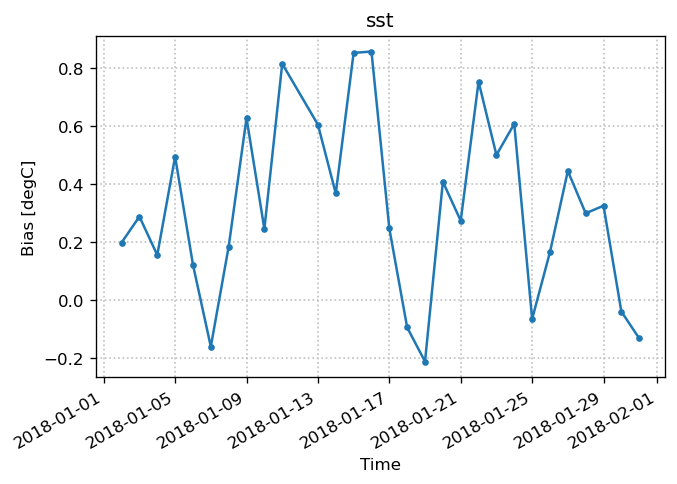

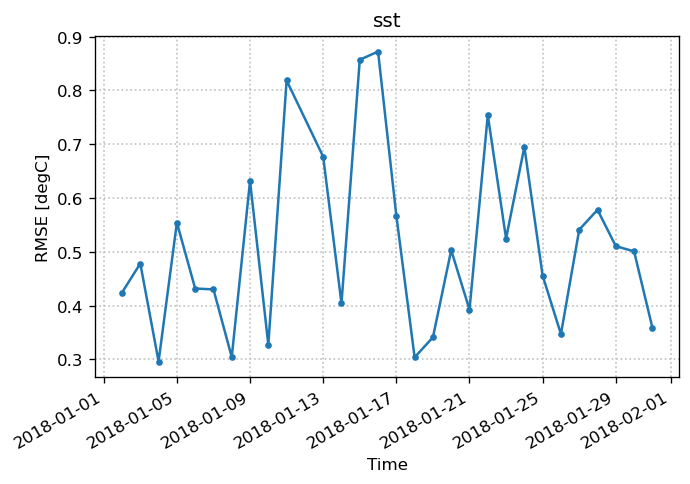

In [10]:
import matplotlib

%matplotlib inline
import matplotlib.pyplot as plt

for metric in ['Bias', 'RMSE']:
    fig = plt.figure(dpi=120)
    ax = plt.axes()

    plt.plot(result['time'].data, result['%s_ts' % metric.lower()], '.-')

    plt.title('sst')
    plt.ylabel('%s [%s]' % (metric, model.attrs['units']))
    plt.xlabel('Time')
    plt.grid(True, c='silver', lw=1, ls=':')
    plt.tight_layout()
    fig.autofmt_xdate()

    plt.savefig('sst_%s.png' % (metric.lower()))

    plt.show()


 Opening figure , 2 rows and 1 cols 

 Plotting with x limits [27.32, 41.96]  
 Plotting with y limits [40.86, 46.8]  
Ten Contours automatic
Contouring from -0.5608645081520081 to 2.018326997756958 with 10 contours
 0.48800000000000004 Ticks set at 30   intervals
 0.19799999999999993 Ticks set at 30   intervals
 Plotting with x limits [27.32, 41.96]  
 Plotting with y limits [40.86, 46.8]  
Ten Contours automatic
Contouring from 0.07943399250507355 to 2.4099953174591064 with 10 contours
 0.48800000000000004 Ticks set at 30   intervals
 0.19799999999999993 Ticks set at 30   intervals


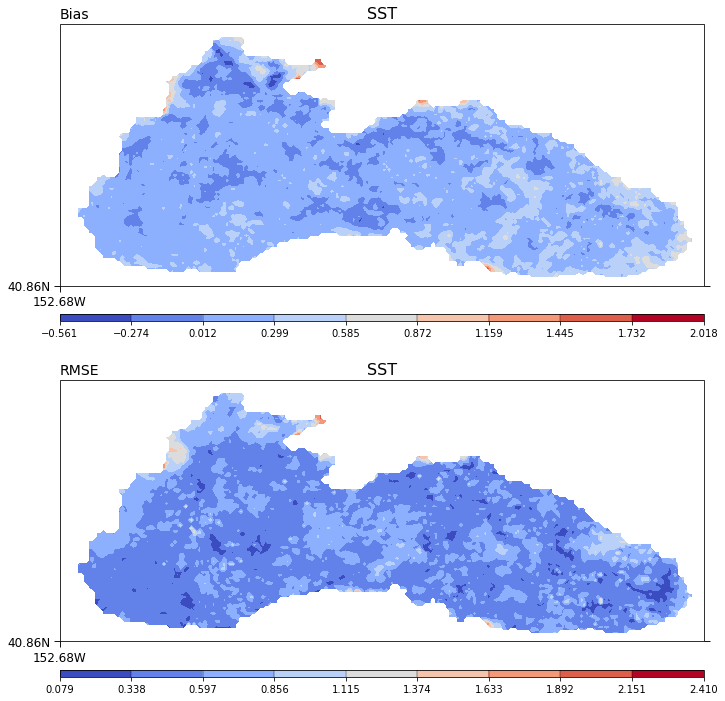

In [11]:
import zapata.mapping as zmap

bigtit = 'SST'
left1 = 'Bias'
left2 = 'RMSE'

fig, ax, pro = zmap.init_figure(2, 1, 'Pacific', constrained_layout=False, figsize=(24, 12))

handle = zmap.xmap(result['bias'], [], pro, ax=ax[0], contour=False, xlimit=[27.32, 41.96], ylimit=[40.86, 46.80], \
                   maintitle=bigtit, lefttitle=left1, cmap='coolwarm')
# Add horizontal colorbar
zmap.add_colorbar(fig, handle['filled'], ax[0], colorbar_size=0.01, label_size=10, edges=True)

han1 = zmap.xmap(result['rmse'], [], pro, ax=ax[1], contour=False, xlimit=[27.32, 41.96], ylimit=[40.86, 46.80], \
                 maintitle=bigtit, lefttitle=left2, cmap='coolwarm')
zmap.add_colorbar(fig, han1['filled'], ax[1], colorbar_size=0.01, label_size=10, edges=True)

fig.subplots_adjust(wspace=0, hspace=0.2)

plt.savefig('SST.pdf')
plt.show()
